In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom
import math

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

# LF dynamics

In [5]:
# load LF files 
z11_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11.txt'
z3_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3.txt'
# load into a list of gene names 
z11 = pd.read_csv(z11_file, sep='\t', header=0)
z3 = pd.read_csv(z3_file, sep='\t', header=0)
# remove HLA- genes
z11 = z11[~z11['names'].str.contains('HLA-')]
z3 = z3[~z3['names'].str.contains('HLA-')]

In [6]:
# get the gene names 
z11_genes = z11['names'].tolist()
z3_genes = z3['names'].tolist()
# create a list of all lf genes 
lf_genes = list(set(z11_genes + z3_genes))
lf_in_object = check_if_gene_in_ndict(dictys_dynamic_object, lf_genes, return_index=True)
print(f"Found {len(lf_in_object['present'])} genes")
print(f"Missing {len(lf_in_object['missing'])} genes")
print("Indices:", lf_in_object['indices'])


Found 57 genes
Missing 0 genes
Indices: {'TRAM1': 10472, 'SLAMF7': 8987, 'CIITA': 1884, 'IRF4': 4652, 'CD79A': 1587, 'UBAC2': 10759, 'TXNDC5': 10727, 'FNDC3A': 3516, 'AFF3': 230, 'MED23': 5675, 'EEA1': 2862, 'TIAM1': 10070, 'PAX5': 6943, 'ELL2': 2979, 'ARFGAP3': 560, 'IGHM': 4421, 'CCSER2': 1534, 'SLA': 8982, 'RNF213': 8355, 'MZB1': 6199, 'PIM2': 7239, 'B2M': 872, 'FNDC3B': 3517, 'CPEB4': 2131, 'DEK': 2479, 'MAPK1': 5543, 'GLCCI1': 3767, 'HSP90B1': 4304, 'TXNDC11': 10722, 'XBP1': 11200, 'SSR1': 9582, 'SEL1L3': 8763, 'PPIB': 7507, 'LMAN1': 5269, 'ANKRD28': 429, 'ARNTL2': 665, 'CD99': 1598, 'IQGAP2': 4638, 'RUNX2': 8586, 'CD74': 1586, 'TNFAIP8': 10337, 'MAN1A1': 5488, 'PDE4D': 7027, 'CD52': 1574, 'CEP128': 1733, 'JCHAIN': 4730, 'TBC1D4': 9887, 'HM13': 4210, 'SLC25A13': 9042, 'CDK6': 1665, 'BTG2': 1106, 'TRAM2': 10473, 'SUB1': 9706, 'GAB1': 3613, 'PIKFYVE': 7235, 'CTSH': 2270, 'PRDM1': 7604}


### Expression dynamics

In [7]:
# get lcpm chars for these genes
lcpm_dcurve_pb, dtime_pb = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=20, dist=0.001, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_pb = lcpm_dcurve_pb.loc[lf_genes]
# get dchars for these genes
#lf_lcpm_dchar_pb = compute_curve_characteristics(lf_lcpm_dcurve_pb, dtime_pb)
# save lf_lcpm_dcurve_pb as pd dataframe pickle
#lf_lcpm_dcurve_pb.to_pickle(os.path.join(output_folder, 'lf_lcpm_dcurve_pb.pkl'))
display(lf_lcpm_dcurve_pb.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
TRAM1,6.589910,6.605276,6.626965,6.656707,6.697018,6.751360,6.824155,6.920476,7.045107,7.200753,7.385631,7.591604,7.804655,8.008516,8.189748,8.341166,8.462001,8.555773,8.627768,8.683270
SLAMF7,6.743035,6.733473,6.726586,6.723068,6.723469,6.728479,6.739185,6.757236,6.784791,6.824103,6.876649,6.942033,7.017313,7.097445,7.176806,7.250861,7.317030,7.374570,7.423963,7.466263
CIITA,6.520920,6.511249,6.498589,6.480643,6.453924,6.413546,6.353126,6.265033,6.141352,5.975973,5.767711,5.523242,5.257545,4.990314,4.739789,4.517787,4.328441,4.170067,4.038011,3.926906
IRF4,7.604007,7.628033,7.654755,7.686040,7.724581,7.774006,7.838860,7.924225,8.034759,8.172935,8.336773,8.518198,8.703711,8.878023,9.028907,9.150282,9.242151,9.308436,9.354537,9.385682
CD79A,8.349367,8.374453,8.404606,8.440038,8.481065,8.528192,8.582120,8.643622,8.713187,8.790417,8.873328,8.958015,9.039190,9.111653,9.171913,9.218947,9.253830,9.278766,9.296192,9.308254


In [8]:
# get lcpm chars for these genes
lcpm_dcurve_gc, dtime_gc = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=20, dist=0.001, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_gc = lcpm_dcurve_gc.loc[lf_genes]
# get dchars for these genes
#lf_lcpm_dchar = compute_curve_characteristics(lf_lcpm_dcurve, dtime)
# save lf_lcpm_dcurve_gc as pickle
#lf_lcpm_dcurve_gc.to_pickle(os.path.join(output_folder, 'lf_lcpm_dcurve_gc.pkl'))
display(lf_lcpm_dcurve_gc.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
BTG2,7.420272,7.413457,7.397993,7.370985,7.328991,7.268447,7.186601,7.082934,6.960630,6.827101,6.692717,6.567953,6.460494,6.373853,6.307802,6.259782,6.226325,6.204008,6.189911,6.181745
SEL1L3,6.875059,6.895291,6.917438,6.942486,6.971663,7.006304,7.047539,7.095800,7.150300,7.208789,7.267927,7.324206,7.374951,7.418839,7.455809,7.486621,7.512383,7.534221,7.553111,7.569833
PIM2,6.315297,6.319965,6.320091,6.312983,6.295282,6.263188,6.213124,6.142930,6.053311,5.948757,5.837040,5.727123,5.626592,5.540008,5.468762,5.411950,5.367487,5.332965,5.306147,5.285163
TIAM1,5.908884,5.940674,5.972177,6.003717,6.035659,6.068333,6.101895,6.136158,6.170454,6.203661,6.234457,6.261713,6.284818,6.303743,6.318899,6.330910,6.340425,6.348016,6.354143,6.359154
PIKFYVE,8.506510,8.515386,8.519008,8.515996,8.504677,8.483300,8.450501,8.406020,8.351443,8.290482,8.228351,8.170344,8.120384,8.080312,8.050095,8.028519,8.013904,8.004582,7.999128,7.996425


### Regulation dynamics


#### Get subnetworks for the dynamic genes in one lineage

In [8]:
pts, fsmooth = dictys_dynamic_object.linspace(0,2,20,0.001)
stat1_net = fsmooth(stat.net(dictys_dynamic_object)) #varname=w_in loads total effect network
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

#### Break into episodes

In [9]:
# pts is a dictys traj object
dnetbin = stat1_netbin.compute(pts)
dnetbin_episode = dnetbin[:, :, :5] #excludes the last one
display(dnetbin_episode.shape)

(551, 11907, 5)

In [ ]:
# compute the weighted network
dnet = stat1_net.compute(pts)
dnet_episode = dnet[:, :, :5]
display(dnet_episode.shape)

In [38]:
# get indices of the dynamic_pb_genes
lf_genes_indices = get_gene_indices(dictys_dynamic_object, lf_genes)
display(len(lf_genes_indices))  

57

### Filter the GRN based on sparsity to only select active nodes (tfs or targets) in that episode

In [73]:
def plot_node_density_vs_sparsity(node_density, total_nodes=None, title='Node density', ylabel='Number of Nodes Retained'):
    """
    Plots the number of nodes retained at different sparsity thresholds.
    Args:
        node_density (np.ndarray): Density array for nodes (e.g., tf_density or target_density).
        total_nodes (int, optional): Total number of nodes for reference line. If None, uses len(node_density).
        title (str): Title for the plot.
        ylabel (str): Y-axis label.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    sparsity_thresholds = np.arange(0, 1.05, 0.05)  # From 0 to 1 in steps of 0.05
    num_nodes = []

    for threshold in sparsity_thresholds:
        nodes_to_keep = node_density > threshold
        num_nodes.append(np.sum(nodes_to_keep))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sparsity_thresholds, num_nodes, 'o-', linewidth=2, color='blue')

    key_thresholds = [0.1, 0.5, 0.7]
    for threshold in key_thresholds:
        idx = np.abs(sparsity_thresholds - threshold).argmin()
        ax.plot(sparsity_thresholds[idx], num_nodes[idx], 'o', markersize=8, 
                color='red', label=f'Threshold={threshold}, Nodes={num_nodes[idx]}')

    ax.fill_between(sparsity_thresholds, num_nodes, alpha=0.3, color='blue')
    ax.set_xlabel('Sparsity Threshold', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if total_nodes is None:
        total_nodes = len(node_density)
    ax.axhline(y=total_nodes, color='gray', linestyle='--', alpha=0.7, 
               label=f'Total nodes: {total_nodes}')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()

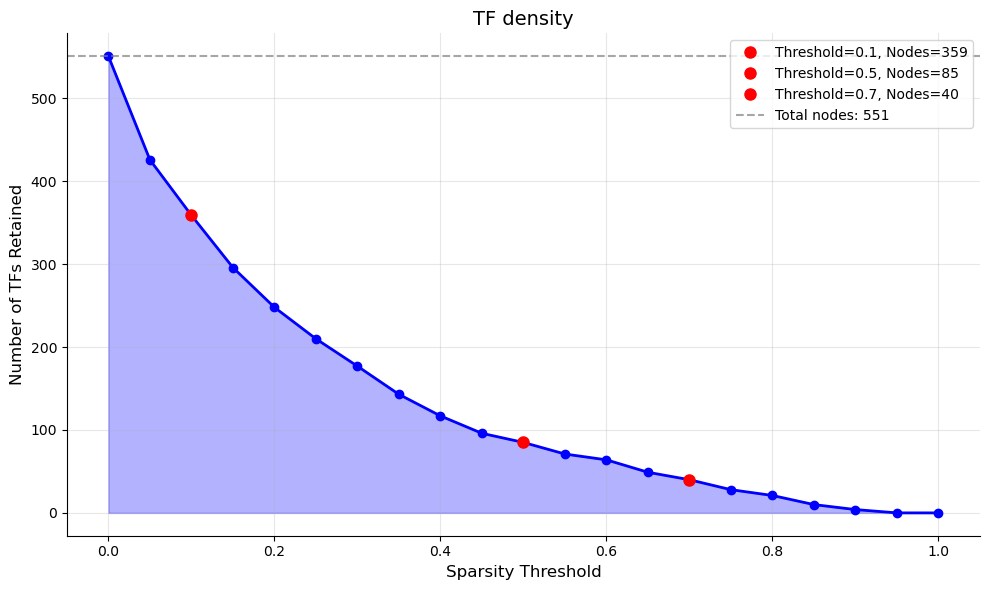

In [76]:
# Calculate sparsity for each TF/Target (across all TFs/Targets and timepoints)
tf_density = (dnet_episode != 0).mean(axis=(1,2))
plot_node_density_vs_sparsity(tf_density, total_nodes=551, title='TF density', ylabel='Number of TFs Retained')

In [90]:
# Keep targets that are non-zero more than x% of the time
tfs_to_keep = tf_density > 0.3
tfs_to_keep_indices = np.where(tfs_to_keep)[0]
display(len(tfs_to_keep_indices))

177

In [91]:
# Get the subnetworks for the kept TFs
dnet_episode_filtered = dnet_episode[np.ix_(tfs_to_keep_indices, range(dnet_episode.shape[1]), range(dnet_episode.shape[2]))]
display(dnet_episode_filtered.shape) 

(177, 11907, 5)

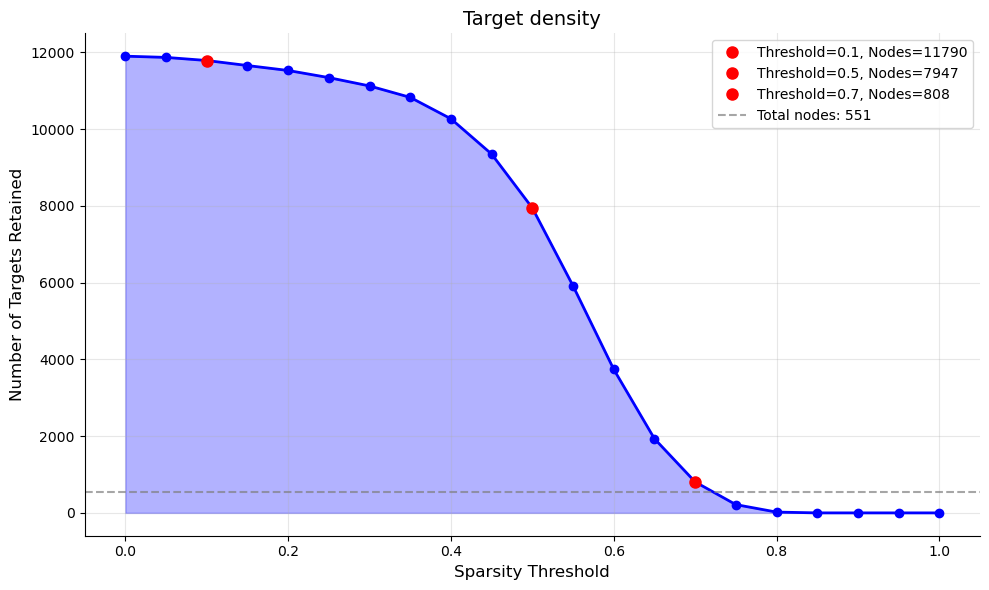

In [92]:
target_density = (dnet_episode_filtered != 0).mean(axis=(0, 2))
plot_node_density_vs_sparsity(target_density, total_nodes=551, title='Target density', ylabel='Number of Targets Retained')

In [94]:
# Keep targets that are non-zero more than x% of the time
targets_to_keep = target_density > 0.6
targets_to_keep_indices = np.where(targets_to_keep)[0]
display(len(targets_to_keep_indices))

3742

In [95]:
# Get the subnetworks for the kept TFs
dnet_episode_filtered = dnet_episode[np.ix_(tfs_to_keep_indices, targets_to_keep_indices, range(dnet_episode.shape[2]))]
display(dnet_episode_filtered.shape) 

(177, 3742, 5)

### Get TF forces for the filtered episodic grn

In [96]:
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
kept_target_names = [index_to_gene[idx] for idx in targets_to_keep_indices]
# Get TF_gene_indices from TFs_to_keep_indices using nids[0]
kept_tf_gene_indices = [dictys_dynamic_object.nids[0][tf_idx] for tf_idx in tfs_to_keep_indices]
kept_tf_names = [index_to_gene[idx] for idx in kept_tf_gene_indices]
print(len(kept_target_names))
print(len(kept_tf_names))

3742
177


In [97]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in kept_tf_names for target in kept_target_names]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = dnet_episode_filtered.shape
reshaped_data = dnet_episode_filtered.reshape(-1, n_times)

# Create DataFrame with multi-index
episode_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(episode_beta_dcurve.head())
display(episode_beta_dcurve.shape)

time_0    time_1    time_2    time_3    time_4
TF  Target                                                  
AHR AAGAB   0.002748  0.003093  0.003473  0.003868  0.004253
    AAK1    0.051921  0.053099  0.053648  0.053687  0.053382
    AAMP    0.011385  0.011082  0.010766  0.010437  0.010115
    AATF    0.005094  0.004598  0.004136  0.003686  0.003238
    ABAT    0.000000  0.000000  0.000000  0.000000  0.000000

(662334, 5)

In [106]:
# get the tf_lcpms for the lineage
tfs_lcpm_dcurve = lcpm_dcurve_pb.loc[list(kept_tf_names)]
# slice the first 5 timepoints axis = 1
tfs_lcpm_dcurve = tfs_lcpm_dcurve.iloc[:, :5]
display(tfs_lcpm_dcurve.head())
display(tfs_lcpm_dcurve.shape)

,0,1,2,3,4
AHR,6.943979,6.963448,6.976820,6.981472,6.975079
ARNTL,4.783038,4.811984,4.840344,4.866302,4.887995
ATF1,5.351297,5.337682,5.323151,5.307643,5.290909
ATF3,4.702321,4.788645,4.867071,4.934452,4.987578
BHLHE40,5.588665,5.725713,5.846748,5.947314,6.023250


(177, 5)

### Get TF forces for the filtered episodic network


In [107]:
episode_all_forces_dcurve = calculate_force_curves(episode_beta_dcurve, tfs_lcpm_dcurve)
episode_all_forces_dcurve = episode_all_forces_dcurve.sort_index(level=1)
display(episode_all_forces_dcurve.head())
display(episode_all_forces_dcurve.shape)

,,time_0,time_1,time_2,time_3,time_4
TF,Target,,,,,
AHR,AAGAB,0.179183,0.188839,0.198752,0.208349,0.217029
ARNTL,AAGAB,0.195566,0.191077,0.186309,0.181246,0.176035
ATF1,AAGAB,0.000000,0.000000,0.000000,0.000000,0.000000
ATF3,AAGAB,0.046468,0.049047,0.048801,0.045663,0.039047
BHLHE40,AAGAB,0.289027,0.293680,0.295151,0.293213,0.287458


(662334, 5)

### Get invariant episodic GRN with links not changing over the episode

In [110]:
def process_target_chunk_for_parallel(targets_chunk_args):
    """
    Process a chunk of targets to find TFs in the top percentile across consecutive timepoints
    """
    from collections import defaultdict
    import numpy as np
    
    targets_chunk, force_df, time_window, percentile, use_abs = targets_chunk_args
    
    # Get the timepoints to analyze
    if time_window is None:
        timepoints = force_df.columns
    else:
        start, end = time_window
        timepoints = force_df.columns[start:end]
    
    # Dictionary to store results for this chunk
    chunk_results = {}
    
    # Process each target in the chunk
    for target in targets_chunk:
        # Dictionary to track consecutive appearances for this target
        tf_consecutive_counts = defaultdict(int)
        
        # Previous timepoint's top TFs
        prev_top_tfs = set()
        
        # Get all TFs for this target
        target_mask = force_df.index.get_level_values(1) == target
        target_data = force_df[target_mask]
        
        # Skip targets with no data
        if len(target_data) == 0:
            continue
            
        # Iterate through timepoints
        for i, timepoint in enumerate(timepoints):
            # Get force values for this timepoint
            forces = target_data[timepoint].values
            
            # Use absolute values if requested
            if use_abs:
                forces = np.abs(forces)
            
            # Calculate the percentile threshold
            threshold = np.percentile(forces, percentile)
            
            # Find TFs above the threshold
            tf_indices = np.where(forces >= threshold)[0]
            
            # Get TF names
            current_top_tfs = set(target_data.index.get_level_values(0)[tf_indices])
            
            # For the first timepoint, just set previous TFs
            if i == 0:
                prev_top_tfs = current_top_tfs
                continue
            
            # Find TFs that appear in both current and previous timepoints
            consecutive_tfs = current_top_tfs.intersection(prev_top_tfs)
            
            # Increment counts for consecutive TFs
            for tf in consecutive_tfs:
                tf_consecutive_counts[tf] += 1
            
            # Update previous timepoint's TFs
            prev_top_tfs = current_top_tfs
        
        # Store results for this target
        if tf_consecutive_counts:
            chunk_results[target] = dict(tf_consecutive_counts)
    
    return chunk_results

def find_top_percentile_tfs_across_time_parallel(force_df, percentile=95, time_window=None, 
                                                use_abs=True, n_jobs=None, chunk_size=100):
    """
    Find TFs that are in the top percentile of force values across consecutive timepoints using parallel processing.
    """
    import multiprocessing as mp
    from tqdm import tqdm
    
    # Get unique targets
    targets = force_df.index.get_level_values(1).unique()
    
    # Set number of processes
    if n_jobs is None:
        n_jobs = mp.cpu_count()
    
    # Split targets into chunks
    target_chunks = [targets[i:i + chunk_size] for i in range(0, len(targets), chunk_size)]
    print(f"Processing {len(targets)} targets in {len(target_chunks)} chunks using {n_jobs} CPU cores...")
    
    # Create arguments list
    args_list = [(chunk, force_df, time_window, percentile, use_abs) for chunk in target_chunks]
    
    # Process in parallel
    with mp.Pool(processes=n_jobs, maxtasksperchild=10) as pool:
        results = list(tqdm(
            pool.imap(process_target_chunk_for_parallel, args_list),
            total=len(target_chunks),
            desc="Finding top percentile TFs"
        ))
    
    # Combine results from all chunks
    combined_results = {}
    for chunk_result in results:
        combined_results.update(chunk_result)
    
    print(f"Found TF persistence data for {len(combined_results)} targets")
    return combined_results

def get_target_specific_regulators_parallel(force_df, percentile=95, time_window=None, 
                                use_abs=True, min_consecutive=1, target_list=None, n_jobs=None, chunk_size=100):
    """
    Find TFs that consistently appear in the top percentile of force values for specific targets.
    Parallel implementation of get_target_specific_regulators.
    """
    # Get TF persistence data for all targets
    target_tf_persistence = find_top_percentile_tfs_across_time_parallel(
        force_df=force_df,
        percentile=percentile,
        time_window=time_window,
        use_abs=use_abs,
        n_jobs=n_jobs,
        chunk_size=chunk_size
    )
    
    # Filter by minimum consecutive appearances and targets of interest
    filtered_persistence = {}
    
    for target, tf_dict in target_tf_persistence.items():
        # Skip if not in target list (when specified)
        if target_list is not None and target not in target_list:
            continue
            
        # Filter TFs by minimum consecutive appearances
        filtered_tfs = {tf: count for tf, count in tf_dict.items() if count >= min_consecutive}
        
        # Only add if there are any TFs left after filtering
        if filtered_tfs:
            filtered_persistence[target] = filtered_tfs
    
    return filtered_persistence

In [171]:
strong_links_subGRN_filtered_tfs = get_target_specific_regulators_parallel(
    force_df=strong_tfs_all_forces_dcurve,
    percentile=90,
    time_window=(15,19),
    use_abs=True,
    min_consecutive=2,
    target_list=None,
    n_jobs=64,
    chunk_size=100
)

Processing 4023 targets in 41 chunks using 64 CPU cores...


Finding top percentile TFs: 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]


Found TF persistence data for 4023 targets


In [69]:
# save the strong_links_subGRN_filtered_tfs as a pickle
#pickle.dump(strong_links_subGRN_filtered_tfs, open(os.path.join(output_folder, 'strong_links_subGRN_filtered_tfs_0_4_90_pb.pkl'), 'wb'))


In [172]:
total_tf_target_pairs = 0
for target, tf_dict in strong_links_subGRN_filtered_tfs.items():
    total_tf_target_pairs += len(tf_dict)
print(f"Total number of TF-target pairs: {total_tf_target_pairs}")

Total number of TF-target pairs: 71994
